In [1]:
from quspin.operators import hamiltonian, commutator, anti_commutator
from quspin.basis import spin_basis_1d
from quspin.tools.evolution import evolve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from qiskit.opflow import X, Z, I, Y

In [2]:
def rhs(tau, phi, h):
    """
    RHS of imaginary time propagation of phi
    :param tau: imaginary time
    :param phi: wavefunction
    :param h:   hamiltonian
    :return:
    """
    return -h.dot(phi)

In [3]:
def get_energy_gap(ham, obs, wf):
    """
    Calculates the energy gap as <wf|[ham, obs]_3|wf>/<wf|[ham, obs]_1|wf>
    :param ham: hamiltonian
    :param obs: observable - just need to overlap gs and 1st excited state
    :param wf:  wavefunction from imaginary time propagation
    :return:    the energy gap
    """
    # Calculate commutators
    sing_comm = commutator(ham, obs)
    trip_comm = commutator(ham, commutator(ham, sing_comm))

    return trip_comm.expt_value(wf) / sing_comm.expt_value(wf)

In [4]:
def alt_get_energy_gap(ham, obs, wf):
    """
    Calculate the energy gap as <wf|[ham, obs]_4|wf>/<wf|[ham, obs]_2|wf>
    :param args:
    :return:
    """
    # Calculate commutators
    sing_comm = commutator(ham, obs)
    doub_comm = commutator(ham, sing_comm)
    quad_comm = commutator(ham, commutator(ham, doub_comm))

    return quad_comm.expt_value(wf) / doub_comm.expt_value(wf)

In [5]:
# Define plotting parameters
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [6]:
# Set the random seed
np.random.seed(1)

In [7]:
# Define model parameters
L = 2  # system size
J = 1  # spin zz interaction
h = 1
basis = spin_basis_1d(L=int(L))

In [8]:
# Define site-coupling lists
h_field = [[-h, i] for i in range(L)]
J_zz = [[-J, i, (i+1) % L] for i in range(L)]
offset = [[3, i] for i in range(L)]

# Define static and dynamic parts
static = [["zz", J_zz], ["x", h_field]]#, ["I", offset]]
dynamic = []

In [9]:
# Create Hamiltonian
H = hamiltonian(static, dynamic, basis=basis, check_symm=False)

# Get eigenvalues and eigenvectors
E, V = H.eigh()

# Calculate square of the exact gap
exact_gap_squared = (E[0] - E[1]) ** 2

# Get the ground and first excited states for checking the overlap of O
gs = V[:, 0]
fst_exc = V[:, 1]

Hermiticity check passed!


In [10]:
H.toarray()

array([[-2.+0.j, -1.+0.j, -1.+0.j,  0.+0.j],
       [-1.+0.j,  2.+0.j,  0.+0.j, -1.+0.j],
       [-1.+0.j,  0.+0.j,  2.+0.j, -1.+0.j],
       [ 0.+0.j, -1.+0.j, -1.+0.j, -2.+0.j]])

In [11]:
# Generate random initial state
phi0 = np.random.random(gs.shape[0]) + 1j*np.random.random(gs.shape[0])
#phi0 = np.arange(gs.shape[0]) + 1j*np.arange(gs.shape[0])
phi0 /= np.sqrt(np.sum(abs(phi0) ** 2))

print("gs dot phi0 = ", gs.conj().T @ phi0)
print("fst dot phi0 = ", fst_exc.conj().T @ phi0)
print(gs)
print(fst_exc)

# Set up imaginary time evolution
tau_inc = np.linspace(0, 5, 1000)

gs dot phi0 =  (0.6756693243175363+0.40344579073307024j)
fst dot phi0 =  (-0.08241239941875789+0.14285521580861768j)
[0.65328148+0.j 0.27059805+0.j 0.27059805+0.j 0.65328148+0.j]
[-7.07106781e-01-0.j -3.92523115e-17+0.j -1.96261557e-16+0.j
  7.07106781e-01+0.j]


In [12]:
# Evolve state
psi_gen = evolve(phi0, tau_inc[0], tau_inc, rhs, f_params=(H,), imag_time=True, iterate=True)
psi = np.array([_ for _ in psi_gen])

Text(0, 0.5, 'Norm of $\\psi$')

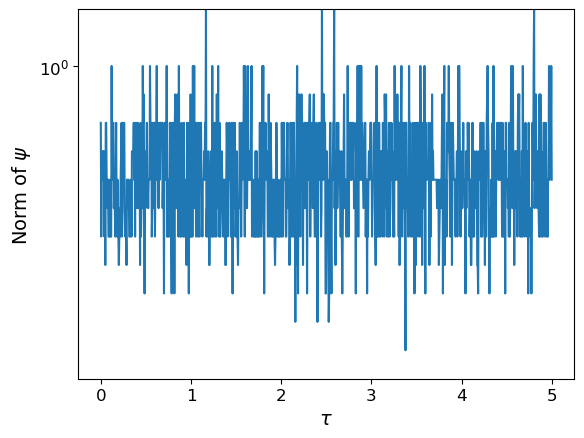

In [13]:
# Check normalization of each psi
norm_factor = [np.sum(abs(_) ** 2) for _ in psi]
plt.semilogy(tau_inc, norm_factor)
plt.xlabel("$\\tau$")
plt.ylabel("Norm of $\\psi$")

In [14]:
# Define observable to use
obs_int = [[-h, i] for i in range(2)]
obs_static = [
    ["z", obs_int]
]
obs_dynamic = []
obs = hamiltonian(obs_static, obs_dynamic, basis=basis, check_symm=False)

# Calculate the single and triple commutators
sing_comm = commutator(H, obs)
trip_comm = commutator(H, commutator(H, sing_comm))

# Verify that observable is good
print("Does O overlap first 2 states?", 
      not np.allclose(fst_exc.conj().T @ obs.toarray() @ gs, 0))
print("[H, O]_1 == 0?", 
      np.allclose(sing_comm.toarray(), np.zeros((gs.shape[0], gs.shape[0]))))
print("[H, 0]_3 == 0?",
     np.allclose(trip_comm.toarray(), np.zeros((gs.shape[0], gs.shape[0]))))

Hermiticity check passed!
Does O overlap first 2 states? True
[H, O]_1 == 0? False
[H, 0]_3 == 0? False


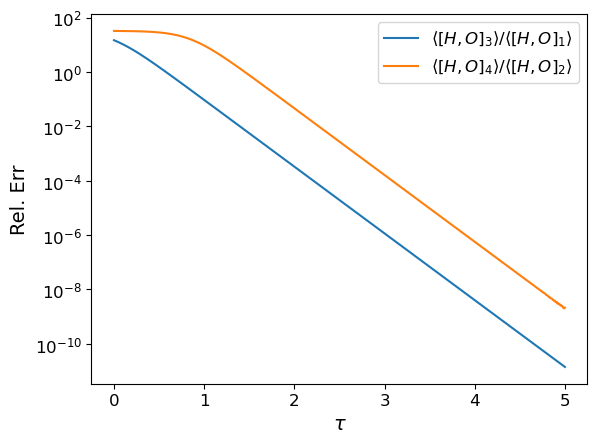

In [15]:
# Calculate energy gap vs tau
calc_gap_sq = np.array([get_energy_gap(H, obs, _) for _ in psi])
alt_gap_sq = np.array([alt_get_energy_gap(H, obs, _) for _ in psi])

# Calculate relative errors
rel_err = abs(exact_gap_squared - calc_gap_sq) / exact_gap_squared
alt_rel_err = abs(exact_gap_squared - alt_gap_sq) / exact_gap_squared
plt.semilogy(tau_inc, rel_err, 
             label='$\\langle[H, O]_3\\rangle / \\langle[H, O]_1\\rangle$')
plt.semilogy(tau_inc, alt_rel_err, 
             label='$\\langle[H, O]_4\\rangle / \\langle[H, O]_2\\rangle$')
plt.xlabel("$\\tau$")
plt.ylabel("Rel. Err")
plt.legend(numpoints=1)

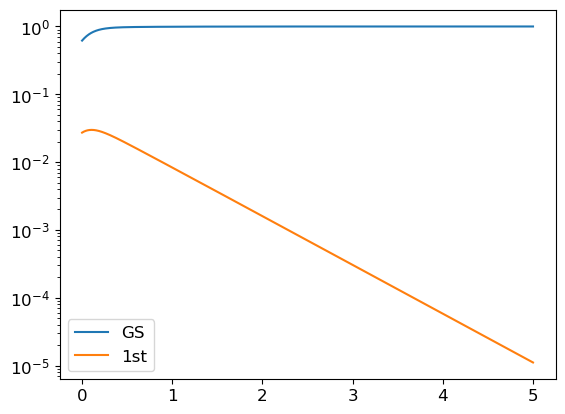

In [16]:
gs_ovlp = np.array([abs(gs.conj().T @ _) ** 2 for _ in psi])
fst_ovlp = np.array([abs(fst_exc.conj().T @ _) ** 2 for _ in psi])
plt.semilogy(tau_inc, gs_ovlp, label='GS')
plt.semilogy(tau_inc, fst_ovlp, label='1st')
plt.legend(numpoints=1)

In [25]:
# Attempt to calculate E1-E2 gap from slope
# Don't want to start at tau=0 and want to end before error stops being linear in log scale
# Get E1-E2 gap
e12_gap = E[1]-E[2]
print("E1-E2 = ", e12_gap)

# Create a test H and use it to see what happens to the e12_gap
static = [["zz", J_zz], ["x", h_field]]
H_test = hamiltonian(static, dynamic, basis=basis, check_symm=False)
E_test, V_test = H_test.eigh()
e12_test = E[1]-E[2]
print("Test e12 gap: ", e12_test)

indx = tau_inc > 2

log_rel_err = np.log(rel_err[indx])
alt_log_rel_err = np.log(alt_rel_err[indx])

reg = LinearRegression().fit(
        tau_inc[indx].reshape(-1, 1),
        log_rel_err.reshape(-1, 1)
    )

alt_reg = LinearRegression().fit(
        tau_inc[indx].reshape(-1, 1),
        alt_log_rel_err.reshape(-1, 1)
    )

# Print slopes
print("===== M = 3, 1 =====")
print("E1-E2 from slope: ", reg.coef_)
print("Relative error: ", np.abs(reg.coef_ - e12_gap) / -e12_gap)
print("===== M = 4, 2 =====")
print("E1-E2 from slope: ", alt_reg.coef_)
print("Relative error: ", np.abs(alt_reg.coef_ - e12_gap) / -e12_gap)

print("E1-E0 = ", E[0] + E[0])
print("slope = ", reg.coef_)
print(E[0]-E[2])

# So slope = 2E[0] for this case...  why?

E1-E2 =  -4.0
Hermiticity check passed!
Test e12 gap:  -4.0
===== M = 3, 1 =====
E1-E2 from slope:  [[-5.65681505]]
Relative error:  [[0.41420376]]
===== M = 4, 2 =====
E1-E2 from slope:  [[-5.65638003]]
Relative error:  [[0.41409501]]
E1-E0 =  -5.65685424949238
slope =  [[-5.65681505]]
-4.82842712474619


E0 + E1 =  -4.82842712474619
Slope of ln|<[H, O]_1>|:  [[-0.84593412]]
Relative error:  [[-1.17519869]]
E1 - E0 =  0.8284271247461894


Text(0, 0.5, 'Ln|<[H, O]_1>|')

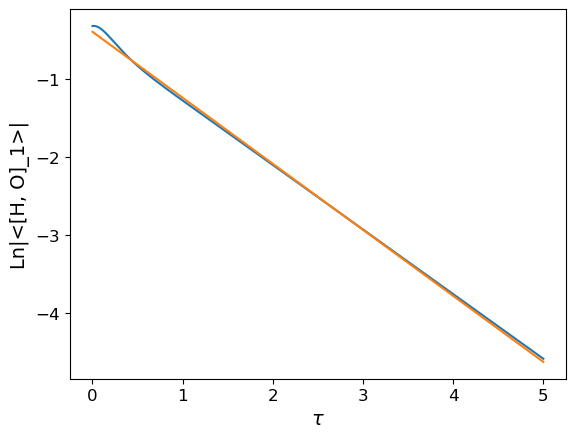

In [20]:
# Attempt to calculate the spectral gap from the slope of <[H, O]_1> and expectation of H
sing_comm_expt_vals = np.array([sing_comm.expt_value(_) for _ in psi])
log_expt_vals = np.log(abs(sing_comm_expt_vals))
indx = tau_inc < 4
sing_comm_reg = LinearRegression().fit(
    tau_inc[indx].reshape(-1, 1),
    log_expt_vals[indx].reshape(-1, 1)
)

# Should be equal to E0 + E1
spectral_sum = E[0] + E[1]
print("E0 + E1 = ", spectral_sum)
print("Slope of ln|<[H, O]_1>|: ", sing_comm_reg.coef_)
print("Relative error: ", np.abs(spectral_sum - -sing_comm_reg.coef_) / spectral_sum)
print("E1 - E0 = ", E[1]-E[0])

plt.plot(tau_inc, log_expt_vals, label='Calculated')
plt.plot(tau_inc, sing_comm_reg.predict(tau_inc.reshape(-1, 1)))
plt.xlabel("$\\tau$")
plt.ylabel("Ln|<[H, O]_1>|")

In [19]:
print(E[2]-E[1])
print(2*(E[1]-E[0]))

4.0
1.6568542494923788
